In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import re
import time
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

----
# 1. Loading and Parsing Data

In [2]:
df = pd.read_csv('RLtest.csv', usecols=[1,2])

head() to see what the data looks like

In [3]:
df.head()

,host,class
0,boqaypuwee.yi.org,dga
1,fotoev.com,legit
2,quickfever.com,legit
3,weareplaystation.fr,legit
4,bxorruxhlkcb.pw,dga


In [4]:
N = df.shape[0]
P = df.shape[1]

print('Data has {} rows, {} columns'.format(N, P))

Data has 10000 rows, 2 columns


In [5]:
df.dtypes

host     object
class    object
dtype: object

In [6]:
list(df)

['host', 'class']

In [7]:
def get_domain(host):
    fullstr = host.split('.')
    domain = fullstr[0]
    return domain

df['domain'] = df['host'].apply(get_domain)
df['domain'][0:5]

0          boqaypuwee
1              fotoev
2          quickfever
3    weareplaystation
4        bxorruxhlkcb
Name: domain, dtype: object

In [8]:
df[0:5]

,host,class,domain
0,boqaypuwee.yi.org,dga,boqaypuwee
1,fotoev.com,legit,fotoev
2,quickfever.com,legit,quickfever
3,weareplaystation.fr,legit,weareplaystation
4,bxorruxhlkcb.pw,dga,bxorruxhlkcb


In [9]:
df['class'].unique()

array(['dga', 'legit'], dtype=object)

In [10]:
df.describe()

,host,class,domain
count,10000,10000,10000
unique,9993,2,9986
top,wvkxdgdtaaymug.net,legit,pmnrqymuo
freq,2,5715,2


### Read in the domains.csv data and print

In [11]:
df_test = pd.read_csv('domains.csv')
df_test.head()

,host,domain,class,subclass
0,000directory.com.ar,000directory,legit,legit
1,000webhost.com,000webhost,legit,legit
2,001fans.com,001fans,legit,legit
3,01-telecharger.com,01-telecharger,legit,legit
4,010shangpu.com,010shangpu,legit,legit


----
# 2. Creating some basic features with apply()

In [12]:
# create some features we think might help us figure out which domains are bad.

def string_length(s):
    length = len(s)
    return length

def string_number_count(s):
    numbers = sum(c.isdigit() for c in s)
    return numbers

def string_alpha_count(s):
    alpha = sum(c.isalpha() for c in s)
    return alpha

def others(s):
    numbers = sum(c.isdigit() for c in s)
    alpha = sum(c.isalpha() for c in s)
    others = len(s) - numbers - alpha
    return others

Use the apply function to create new feature columns

In [13]:
df['numbers'] = df['domain'].apply(string_number_count)
df['other_chars'] = df['domain'].apply(others)
df['alpha'] = df['domain'].apply(string_alpha_count)
df['length'] = df['domain'].apply(string_length)

In [14]:
df.head()

,host,class,domain,numbers,other_chars,alpha,length
0,boqaypuwee.yi.org,dga,boqaypuwee,0,0,10,10
1,fotoev.com,legit,fotoev,0,0,6,6
2,quickfever.com,legit,quickfever,0,0,10,10
3,weareplaystation.fr,legit,weareplaystation,0,0,16,16
4,bxorruxhlkcb.pw,dga,bxorruxhlkcb,0,0,12,12


----
# 3. Explore the Data

In [15]:
df.describe()

,numbers,other_chars,alpha,length
count,10000.00000,10000.000000,10000.000000,10000.000000
mean,0.45880,0.071100,12.669000,13.198900
std,2.11829,0.305703,5.444043,5.968878
min,0.00000,0.000000,0.000000,1.000000
25%,0.00000,0.000000,8.000000,9.000000
50%,0.00000,0.000000,12.000000,12.000000
75%,0.00000,0.000000,16.000000,17.000000
max,25.00000,5.000000,40.000000,42.000000


Understand how your input variables are distributed

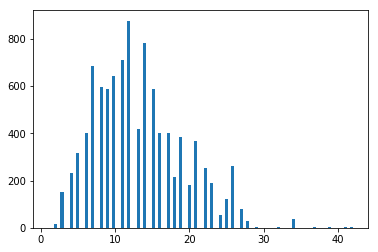

In [16]:
plt.hist(df['length'], bins=100)
plt.show()

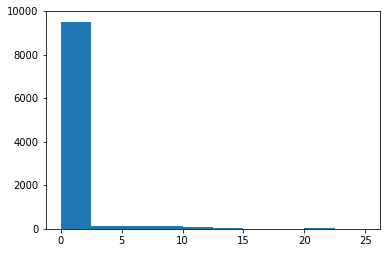

In [17]:
plt.hist(df['numbers'], bins=10)
plt.show()

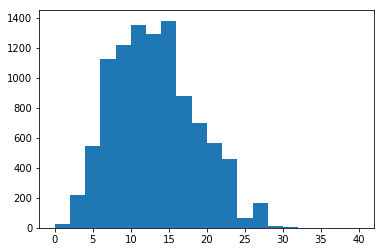

In [18]:
plt.hist(df['alpha'], bins=20)
plt.show()

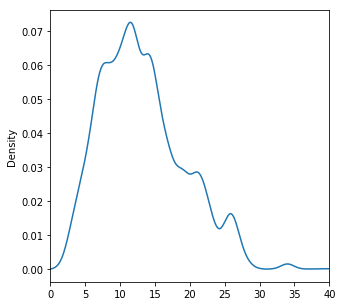

In [19]:
df['length'].plot(kind="density",
              figsize=(5,5), xlim=(0,40))

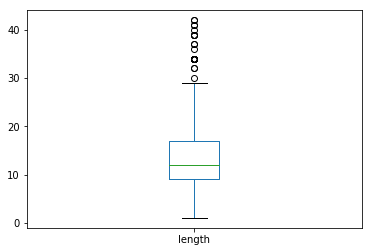

In [20]:
df['length'].plot(kind='box')

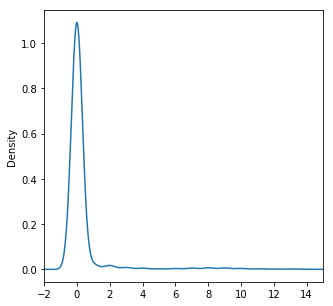

In [21]:
df['numbers'].plot(kind='density', figsize=(5,5), xlim=(-2,15))

In [22]:
def plot_ecdfs(data, fields, n=1000, prob_cutoff=0.01):
    '''plot empirical CDFs between probability range [prob_cutoff, 1.0-prob_cutoff]'''
    x = [(prob_cutoff + (1.0 - prob_cutoff * 2) * i / n) for i in range(n + 1)]
    nrows = np.ceil(len(fields) / 3)
    plt.figure(figsize=(16, 4 * nrows))
    for i, field in enumerate(fields):
        plt.subplot(nrows, 3, i + 1)
        plt.plot(data[field].quantile(x), x)
        plt.title(field)
        
def plot_hists(data, fields, bins=20, prob_cutoff=0.01):
    '''plot histograms for data whose empirical mass is in range [prob_cutoff, 1.0-prob_cutoff]'''
    nrows = np.ceil(len(fields) / 3)
    plt.figure(figsize=(16, 4 * nrows))
    for i, field in enumerate(fields):
        plt.subplot(nrows, 3, i + 1)
        min_val = data[field].quantile(prob_cutoff)
        max_val = data[field].quantile(1.0 - prob_cutoff)
        y = data[(data[field] >= min_val) & (data[field] <= max_val)][field]
        plt.hist(y, bins = bins)
        plt.title(field)

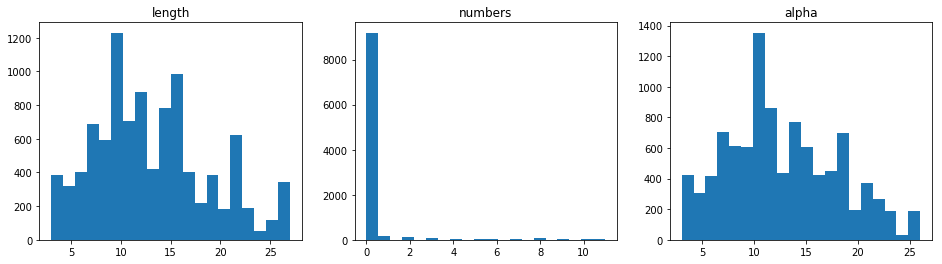

In [23]:
plot_hists(df, ['length', 'numbers', 'alpha'])

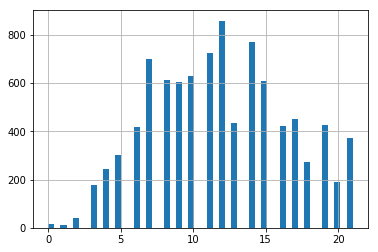

In [24]:
threshold = 0.90
threshold_val = df['alpha'].quantile(threshold)
df[df['alpha'] <= threshold_val]['alpha'].hist(bins=50)

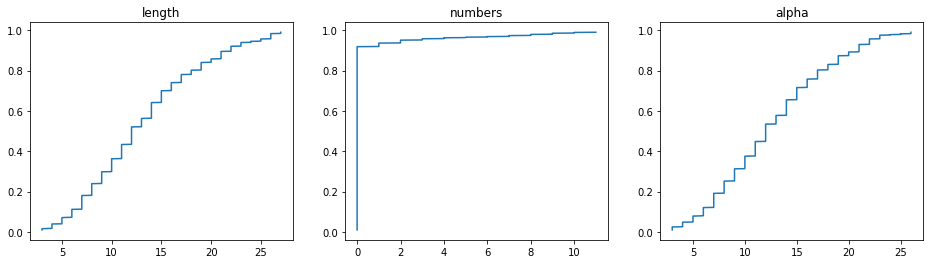

In [25]:
plot_ecdfs(df, ['length', 'numbers', 'alpha'])

----
# 4. Try to predict badness using a simple separator

Encode Target Variable

In [26]:
def is_bad(string):
    if string == 'dga':
        return 1
    else:
        return 0

df['is_bad']=df['class'].apply(is_bad)

In [27]:
df.head()

,host,class,domain,numbers,other_chars,alpha,length,is_bad
0,boqaypuwee.yi.org,dga,boqaypuwee,0,0,10,10,1
1,fotoev.com,legit,fotoev,0,0,6,6,0
2,quickfever.com,legit,quickfever,0,0,10,10,0
3,weareplaystation.fr,legit,weareplaystation,0,0,16,16,0
4,bxorruxhlkcb.pw,dga,bxorruxhlkcb,0,0,12,12,1


In [28]:
pd.crosstab(df['is_bad'], df['numbers'])

numbers,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
is_bad,,,,,,,,,,,,,,,,,,,,,
0,5335,159,125,54,31,7,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3855,15,21,20,16,17,33,47,60,56,...,4,3,4,5,6,8,2,7,5,1


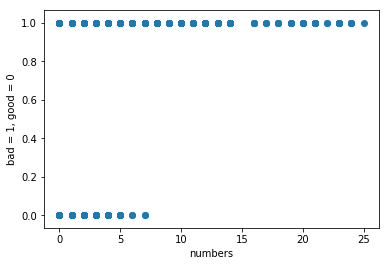

In [29]:
plt.scatter(df['numbers'],df['is_bad'])
plt.xlabel('numbers')
plt.ylabel('bad = 1, good = 0')
plt.show()

### Maybe numbers is a good separator, lets look at another variable

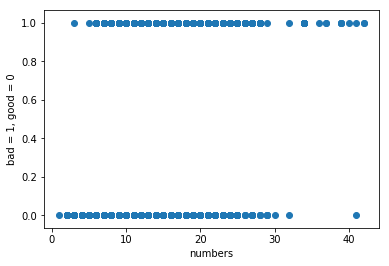

In [30]:
plt.scatter(df['length'],df['is_bad'])
plt.xlabel('numbers')
plt.ylabel('bad = 1, good = 0')
plt.show()

### What if we combine them?

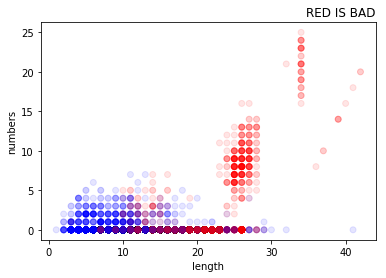

In [31]:
color= ['red' if c == 1 else 'blue' for c in df['is_bad']]
plt.scatter(df['length'],df['numbers'], color=color, alpha = .1)
plt.xlabel('length')
plt.ylabel('numbers')
plt.title('RED IS BAD',loc='right')
plt.show()


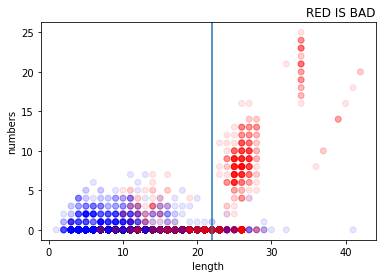

In [32]:
color= ['red' if c == 1 else 'blue' for c in df['is_bad']]
plt.scatter(df['length'],df['numbers'], color=color, alpha = .1)
plt.axvline(x=22)
plt.xlabel('length')
plt.ylabel('numbers')
plt.title('RED IS BAD',loc='right')
plt.show()


### Create a very simple model:

In [33]:
def separate(length):
    if length > 22:
        return 1
    else:
        return 0

df['model_1_pred']= df['length'].apply(separate)

In [34]:
y_pred = df['model_1_pred']
y_actual = df['is_bad']

from sklearn.metrics import accuracy_score

score = accuracy_score(y_actual, y_pred)
score

0.6378

#### Not so great...maybe we need some new features.

In [35]:
df = df.drop(['model_1_pred'], axis=1)

----
# 5. Supervised model creation

In [36]:
ignore_cols = set(['is_bad', 'subclass', 'class', 'domain', 'host', 'TLD', 'gibberish'])
features = list(set(df) - ignore_cols)
features

['alpha', 'length', 'other_chars', 'numbers']

In [37]:
df[features].dtypes.head()

alpha          int64
length         int64
other_chars    int64
numbers        int64
dtype: object

In [38]:
types = ['float', 'int64', 'object']

for i in types:
    print(str(i) + "s: " + str(list(df.loc[:0, df.dtypes == i])))

floats: []
int64s: ['numbers', 'other_chars', 'alpha', 'length', 'is_bad']
objects: ['host', 'class', 'domain']


In [39]:
from sklearn.model_selection import train_test_split
from sklearn import metrics 


X= df[features]
y = df['is_bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)
print("Train Set Size: %d" % len(X_train))
print("Test Set Size: %d" % len(X_test))

Train Set Size: 9000
Test Set Size: 1000


Let's try a logistic regression model to see how it does in terms of speed and accuracy...

In [40]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
start = time.time()
lm.fit(X_train, y_train)
train_time = time.time() - start
start = time.time()
y_pred = lm.predict(X_test)
pred_time = time.time() - start
score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.754000, Train Time: 0.010000, Predict Time: 0.000000


----
## Exercise: Implement one of the following classifiers and measure accuracy/speed on  data
Should include the following:
* sklearn.ensemble.RandomForestClassifier (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* sklearn.tree.DecisionTreeClassifier (http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* sklearn.svm.LinearSVC (http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
* sklearn.neural_network.MLPClassifier (http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
* sklearn.neighbors.KNeighborsClassifier (http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

Feel free to explore hyperparameter settings other than the defaults.

In [73]:
from sklearn.ensemble import RandomForestClassifier
# Fill in classifier here
from sklearn.datasets import make_classification


#clf = RandomForestClassifier(max_depth=2, random_state=0)
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=7, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1, oob_score=False, random_state=1, verbose=0, warm_start=True)

start = time.time()
clf.fit(X_train, y_train)
train_time = time.time() - start

start = time.time()
y_pred = clf.predict(X_test)
pred_time = time.time() - start

score = accuracy_score(y_test, y_pred)

print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.792000, Train Time: 0.040000, Predict Time: 0.002000


In [74]:
from sklearn.tree import DecisionTreeClassifier
# Fill in classifier here

dt = DecisionTreeClassifier()

start = time.time()
dt.fit(X_train, y_train)
train_time = time.time() - start

start = time.time()
y_pred = dt.predict(X_test)
pred_time = time.time() - start

score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.793000, Train Time: 0.000000, Predict Time: 0.000000


In [76]:
from sklearn.svm import LinearSVC
# Fill in classifier here
svc = LinearSVC()

start = time.time()
svc.fit(X_train, y_train)
train_time = time.time() - start

start = time.time()
y_pred = svc.predict(X_test)
pred_time = time.time() - start

score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.779000, Train Time: 0.423033, Predict Time: 0.000000


In [77]:
from sklearn.neural_network import MLPClassifier
# Fill in classifier here
mlp = MLPClassifier()

start = time.time()
mlp.fit(X_train, y_train)
train_time = time.time() - start

start = time.time()
y_pred = mlp.predict(X_test)
pred_time = time.time() - start

score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.733000, Train Time: 0.420038, Predict Time: 0.000000


In [78]:
from sklearn.neighbors import KNeighborsClassifier
# Fill in classifier here
knn = KNeighborsClassifier()

start = time.time()
knn.fit(X_train, y_train)
train_time = time.time() - start

start = time.time()
y_pred = knn.predict(X_test)
pred_time = time.time() - start

score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.771000, Train Time: 0.017002, Predict Time: 0.014001


---- 
### Moar features!  Let's add some more advanced features to our models and see what happens.

In [ ]:
df1 = df.copy()

In [ ]:
#extract the Top-Level-Domain
def find_tld(s):
    domains = s.split(".")
    tld = domains[-1]
    return tld

#truncate domains to reduce levels
def shorten(tld):
    return tld[:4]

#count vowels
vowels = ['a','e','i','o','u','y']
def vowel_count(string):
    vcount = 0
    for i in vowels:
        vcount += str(string).count(i)
    return vcount

#string entropy calculation: 
def entropy(string):
        #"Calculates the Shannon entropy of a string"
        prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]
        # calculate the entropy
        entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])
        return entropy

#simply count # of domains
def num_domains(column):
    return str(column).count('.')+1


#potential exercise (find all consecutive substrings of 3+ non-vowels)
def find_gibberish(string):
    gibberish = []
    gibs = re.findall(r'[^aeiouy]{3,}', string)
    for j in gibs:
        gibberish.append(j)
    return gibberish

def list_len(column):
    return len(column)

def avg_len(column):
    total = 0
    for i in column:
        total += len(i)
    if len(column) > 0:
        return float(total)/len(column)
    else:
        return 0

def find_max(column):
    if len(column)>0:
        return len(max(column, key=len))
    else:
        return 0
    
df1['entropy'] = df1['domain'].apply(entropy)
df1['TLD'] = df1['host'].apply(find_tld)
df1['tld_length']=df1['TLD'].apply(string_length)
df1['vowel_count']=df1['domain'].apply(vowel_count)
df1['v_ratio']=df1['vowel_count']/df['length']
df1['num_domains']=df1['host'].apply(num_domains)
df1['num_density']=df1['numbers']/df['length']
df1['gibberish']=df1['domain'].apply(find_gibberish)
df1['gibberish_amount']=df1['gibberish'].apply(list_len)
df1['gibberish_avg']=df1['gibberish'].apply(avg_len)

In [ ]:
features = list(set(df1) - ignore_cols)
features

In [ ]:
X = df1[features]
y = df1['is_bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)
print("Train Set Size: %d" % len(X_train))
print("Test Set Size: %d" % len(X_test))

Let's test on the logistic regression model with new features...

In [ ]:
lm = LogisticRegression()
start = time.time()
lm.fit(X_train, y_train)
train_time = time.time() - start
start = time.time()
y_pred = lm.predict(X_test)
pred_time = time.time() - start
score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

----
## Exercise: Implement one of the following classifiers and measure accuracy/speed on  data
Should include the following:
* sklearn.ensemble.RandomForestClassifier (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* sklearn.tree.DecisionTreeClassifier (http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* sklearn.svm.LinearSVC (http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
* sklearn.neural_network.MLPClassifier (http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
* sklearn.neighbors.KNeighborsClassifier (http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

Feel free to explore hyperparameter settings other than the defaults.

In [ ]:
# Fill in classifier here
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

In [ ]:
# Fill in classifier here
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

In [ ]:
# Fill in classifier here
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

In [ ]:
# Fill in classifier here
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

In [ ]:
# Fill in classifier here
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))